# Data Preparation

Here in this data preparation jupyter notebook, we will prepare our data that will go into a Convolutional Neural Network model later.

## 0. Setup parameters and load libraries

In [1]:
import glob
import hashlib
import io
import json
import os
import shutil
import sys

import requests
import tqdm
import yaml

import gmt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import quilt
import rasterio
import rasterio.mask
import rasterio.plot
import shapely.geometry
import skimage.util.shape

print('Python       :', sys.version.split('\n')[0])
print('GMT          :', gmt.__version__)
print('Numpy        :', np.__version__)
print('Rasterio     :', rasterio.__version__)
print('Scikit-image :', skimage.__version__)

Python       : 3.6.6 | packaged by conda-forge | (default, Oct 11 2018, 14:33:06) 
GMT          : 0.1a3+131.g9772fa3
Numpy        : 1.14.5
Rasterio     : 1.0.9
Scikit-image : 0.14.1


## 1. Get Data!

In [2]:
def download_to_path(path:str, url:str):
    r"""
    Download from a url to a path
    
    >>> download_to_path(path="highres/Data_20171204_02.csv",
    ...                  url="https://data.cresis.ku.edu/data/rds/2017_Antarctica_Basler/csv_good/Data_20171204_02.csv")
    <Response [200]>
    >>> open("highres/Data_20171204_02.csv").readlines()
    ['LAT,LON,UTCTIMESOD,THICK,ELEVATION,FRAME,SURFACE,BOTTOM,QUALITY\n']
    >>> os.remove(path="highres/Data_20171204_02.csv")
    """
    #if not os.path.exists(path=path):
    r = requests.get(url=url, stream=True)
    with open(file=path, mode='wb') as fd:
        for chunk in r.iter_content(chunk_size=1024):
            fd.write(chunk)
    return r

In [3]:
def check_sha256(path: str):
    """
    Returns SHA256 checksum of a file
    
    >>> download_to_path(path="highres/Data_20171204_02.csv",
    ...                  url="https://data.cresis.ku.edu/data/rds/2017_Antarctica_Basler/csv_good/Data_20171204_02.csv")
    <Response [200]>
    >>> check_sha256("highres/Data_20171204_02.csv")
    '53cef7a0d28ff92b30367514f27e888efbc32b1bda929981b371d2e00d4c671b'
    >>> os.remove(path="highres/Data_20171204_02.csv")
    """
    with open(file=path, mode="rb") as afile:
        sha = hashlib.sha256(afile.read())

    return sha.hexdigest()

## Parse [data_list.yml](/data_list.yml)

In [4]:
def parse_datalist(
    yaml_file: str = "data_list.yml",
    record_path: str = "files",
    schema: list = [
        "citekey",
        "folder",
        "location",
        "resolution",
        ["doi", "dataset"],
        ["doi", "literature"],
    ],
) -> pd.DataFrame:

    assert yaml_file.endswith((".yml", ".yaml"))

    with open(file=yaml_file, mode="r") as yml:
        y = yaml.load(stream=yml)

    datalist = pd.io.json.json_normalize(
        data=y, record_path=record_path, meta=schema, sep="_"
    )

    return datalist

In [5]:
# Pretty print table with nice column order and clickable url links
pprint_table = (
    lambda df, folder: df.loc[df["folder"] == folder]
    .reindex(columns=["folder", "filename", "url", "sha256"])
    .style.format({"url": lambda url: f'<a target="_blank" href="{url}">{url}</a>'})
)
dataframe = parse_datalist()

In [6]:
# Code to autogenerate README.md files in highres/lowres/misc folders from data_list.yml
columns = ["Filename", "Location", "Resolution", "Literature Citation", "Data Citation"]
for folder, md_header in [("lowres", "Low Resolution"),
                          ("highres", "High Resolution"),
                          ("misc", "Miscellaneous")]:
    assert(folder in pd.unique(dataframe["folder"]))
    md_name = f"{folder}/README.md"
    
    with open(file=md_name, mode="w") as md_file:
        md_file.write(f"# {md_header} Antarctic datasets\n\n")
        md_file.write("Note: This file was automatically generated from ")
        md_file.write("[data_list.yml](/data_list.yml) using ")
        md_file.write("[data_prep.ipynb](/data_prep.ipynb)\n\n")
        
    md_table = pd.DataFrame(columns=columns)
    md_table.loc[0] = ['---','---','---','---','---']
    
    keydf = dataframe.groupby("citekey").aggregate(lambda x: set(x).pop())
    for row in keydf.loc[keydf["folder"] == folder].itertuples():
        filecount = len(dataframe[dataframe["citekey"] == row.Index])
        extension = os.path.splitext(row.filename)[-1]
        row_dict = {"Filename": row.filename if filecount == 1 else f"{filecount} *{extension} files",
                    "Location": row.location,
                    "Resolution": row.resolution,
                    "Literature Citation": f"[{row.Index}]({row.doi_literature})",
                    "Data Citation": f"[DOI]({row.doi_dataset})" if row.doi_dataset!='nan' else None}
        md_table = md_table.append(other=row_dict, ignore_index=True)
    
    md_table.to_csv(path_or_buf=md_name, mode='a', sep="|", index=False)

### Download Low Resolution bed elevation data (e.g. [BEDMAP2](https://doi.org/10.5194/tc-7-375-2013))

In [7]:
for dataset in dataframe.loc[dataframe["folder"] == "lowres"].itertuples():
    path = f"{dataset.folder}/{dataset.filename}" #path to download the file to
    if not os.path.exists(path=path):
        download_to_path(path=path, url=dataset.url)
    assert(check_sha256(path=path) == dataset.sha256)
pprint_table(dataframe, "lowres")

,folder,filename,url,sha256
0,lowres,bedmap2_bed.tif,http://data.pgc.umn.edu/elev/dem/bedmap2/bedmap2_bed.tif,28e2ca7656d61b0bc7f8f8c1db41914023e0cab1634e0ee645f38a87d894b416


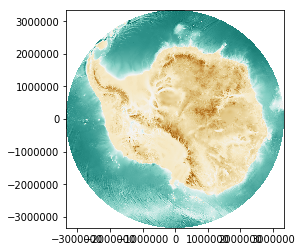

In [8]:
with rasterio.open("lowres/bedmap2_bed.tif") as raster_source:
    rasterio.plot.show(source=raster_source, cmap='BrBG_r')

### Download miscellaneous data (e.g. [REMA](https://doi.org/10.7910/DVN/SAIK8B), [MEaSUREs Ice Flow](https://doi.org/10.5067/OC7B04ZM9G6Q))

In [9]:
for dataset in dataframe.loc[dataframe["folder"] == "misc"].itertuples():
    path = f"{dataset.folder}/{dataset.filename}" #path to download the file to
    if not os.path.exists(path=path):
        download_to_path(path=path, url=dataset.url)
    assert(check_sha256(path=path) == dataset.sha256)
pprint_table(dataframe, "misc")

,folder,filename,url,sha256
1,misc,REMA_200m_dem_filled.tif,http://data.pgc.umn.edu/elev/dem/setsm/REMA/mosaic/v1.0/200m/REMA_200m_dem_filled.tif,8ac252e40810ac5e59934879a066f496c847936771f318dab2ab4a257052d964
2,misc,MEaSUREs_IceFlowSpeed_450m.tif,http://data.pgc.umn.edu/gis/packages/quantarctica/Quantarctica3/Glaciology/MEaSUREs%20Ice%20Flow%20Velocity/MEaSUREs_IceFlowSpeed_450m.tif,4a4efc3a84204c3d67887e8d7fa1186467b51e696451f2832ebbea3ca491c8a8


### Download High Resolution bed elevation data (e.g. some-DEM-name)

In [10]:
for dataset in dataframe.loc[dataframe["folder"] == "highres"].itertuples():
    path = f"{dataset.folder}/{dataset.filename}" #path to download the file to
    if not os.path.exists(path=path):
        download_to_path(path=path, url=dataset.url)
    assert(check_sha256(path=path) == dataset.sha256)
pprint_table(dataframe, "highres")

,folder,filename,url,sha256
3,highres,bed_WGS84_grid.txt,http://ramadda.nerc-bas.ac.uk/repository/entry/get/Polar%20Data%20Centre/DOI/Rutford%20Ice%20Stream%20bed%20elevation%20DEM%20from%20radar%20data/bed_WGS84_grid.txt?entryid=synth%3A54757cbe-0b13-4385-8b31-4dfaa1dab55e%3AL2JlZF9XR1M4NF9ncmlkLnR4dA%3D%3D,7396e56cda5adb82cecb01f0b3e01294ed0aa6489a9629f3f7e8858ea6cb91cf
4,highres,2007t1.txt,nan,04bdbd3c8e814cbc8f0d324277e339a46cc90a8dc23434d11815a8966951e766
5,highres,2007tr.txt,nan,3858a1e58e17b2816920e1b309534cee0391f72a6a0aa68d57777b030e70e9a3
6,highres,2010tr.txt,nan,751ea56acc5271b3fb54893ed59e05ff485187a6fc5daaedf75946d730805b80
7,highres,istar08.txt,nan,ed03c64332e8d406371c74a66f3cd21fb3f78ee498ae8408c355879bb89eb13d
8,highres,istar18.txt,nan,3e69d86f28e26810d29b0b9309090684dcb295c0dd39007fe9ee0d1285c57804
9,highres,istar15.txt,nan,59c981e8c96f73f3a5bd98be6570e101848b4f67a12d98a577292e7bcf776b17
10,highres,istar13.txt,nan,f5bcf80c7ea5095e2eabf72b69a264bf36ed56af5cb67976f9428f560e5702a2
11,highres,istar17.txt,nan,f51a674dc27d6e0b99d199949a706ecf96ea807883c1901fea186efc799a36e8
12,highres,istar07.txt,nan,c81ec04290433f598ce4368e4aae088adeeabb546913edc44c54a5a5d7593e93


## 2. Process high resolution data into grid format

Our processing step involves two stages:

1) Cleaning up the raw **vector** data, performing necessary calculations and reprojections to EPSG:3031.

2) Convert the cleaned vector data table via an interpolation function to a **raster** grid.

### 2.1 [Raw ASCII Text](https://pdal.io/stages/readers.text.html) to [Clean XYZ table](https://gmt.soest.hawaii.edu/doc/latest/GMT_Docs.html#table-data)

![Raw ASCII to Clean Table via pipeline file](https://yuml.me/diagram/scruffy;dir:LR/class/[Raw-ASCII-Text|*.csv/*.txt]->[Pipeline-File|*.json],[Pipeline-File]->[Clean-XYZ-Table|*.xyz])

In [11]:
def ascii_to_xyz(pipeline_file: str) -> pd.DataFrame:
    """
    Converts ascii txt/csv files to xyz pandas.DataFrame via
    a JSON Pipeline file similar to the one used by PDAL.

    >>> os.makedirs(name="/tmp/highres", exist_ok=True)
    >>> download_to_path(path="/tmp/highres/2011_Antarctica_TO.csv",
    ...                  url="https://data.cresis.ku.edu/data/rds/2011_Antarctica_TO/csv_good/2011_Antarctica_TO.csv")
    <Response [200]>
    >>> _ = shutil.copy(src="highres/20xx_Antarctica_TO.json", dst="/tmp/highres")
    >>> df = ascii_to_xyz(pipeline_file="/tmp/highres/20xx_Antarctica_TO.json")
    >>> df.head(2)
                   x             y         z
    0  345580.826265 -1.156471e+06 -377.2340
    1  345593.322948 -1.156460e+06 -376.6332
    >>> shutil.rmtree(path="/tmp/highres")
    """
    assert os.path.exists(pipeline_file)
    assert pipeline_file.endswith((".json"))

    # Read json file first
    j = json.loads(open(pipeline_file).read())
    jdf = pd.io.json.json_normalize(j, record_path="pipeline")
    jdf = jdf.set_index(keys="type")
    reader = jdf.loc["readers.text"]  # check how to read the file(s)

    ## Basic table read
    skip = int(reader.skip)  # number of header rows to skip
    sep = reader.separator  # delimiter to use
    names = reader.header.split(sep=sep)  # header/column names as list
    usecols = reader.usecols.split(sep=sep)  # column names to use

    path_pattern = os.path.join(os.path.dirname(pipeline_file), reader.filename)
    files = [file for file in glob.glob(path_pattern)]
    assert len(files) > 0  # check that there are actually files being matched!

    df = pd.concat(
        pd.read_table(f, sep=sep, header=skip, names=names, usecols=usecols)
        for f in files
    )
    df.reset_index(drop=True, inplace=True)  # reset index after concatenation

    ## Advanced table read with conversions
    try:
        # Perform math operations
        newcol, expr = reader.converters.popitem()
        df[newcol] = df.eval(expr=expr)
        # Drop unneeded columns
        dropcols = reader.dropcols.split(sep=sep)
        df.drop(columns=dropcols, inplace=True)
    except AttributeError:
        pass

    assert len(df.columns) == 3  # check that we have 3 columns i.e. x, y, z
    df.sort_index(axis="columns", inplace=True)  # sort cols alphabetically
    df.set_axis(labels=["x", "y", "z"], axis="columns", inplace=True)  # lower case

    ## Reproject x and y coordinates if necessary
    try:
        reproject = jdf.loc["filters.reprojection"]
        p1 = pyproj.Proj(init=reproject.in_srs)
        p2 = pyproj.Proj(init=reproject.out_srs)
        reproj_func = lambda x, y: pyproj.transform(p1=p1, p2=p2, x=x, y=y)

        x2, y2 = reproj_func(np.array(df["x"]), np.array(df["y"]))
        df["x"] = pd.Series(x2)
        df["y"] = pd.Series(y2)

    except KeyError:
        pass

    return df

In [12]:
xyz_dict = {}
for pf in sorted(glob.glob("highres/*.json")):
    print(f"Processing {pf} pipeline", end=' ... ')
    name = os.path.splitext(os.path.basename(pf))[0]
    xyz_dict[name] = ascii_to_xyz(pipeline_file=pf)
    print(f"{len(xyz_dict[name])} datapoints")

Processing highres/2007tx.json pipeline ... 42995 datapoints
Processing highres/2010tr.json pipeline ... 84922 datapoints
Processing highres/201x_Antarctica_Basler.json pipeline ... 2325792 datapoints
Processing highres/20xx_Antarctica_DC8.json pipeline ... 12840213 datapoints
Processing highres/20xx_Antarctica_TO.json pipeline ... 2895926 datapoints
Processing highres/bed_WGS84_grid.json pipeline ... 244279 datapoints
Processing highres/istarxx.json pipeline ... 396369 datapoints


### 2.2 [Clean XYZ table](https://gmt.soest.hawaii.edu/doc/latest/GMT_Docs.html#table-data) to [Raster Grid](https://gmt.soest.hawaii.edu/doc/latest/GMT_Docs.html#grid-files)

![Clean XYZ Table to Raster Grid via interpolation function](https://yuml.me/diagram/scruffy;dir:LR/class/[Clean-XYZ-Table|*.xyz]->[Interpolation-Function],[Interpolation-Function]->[Raster-Grid|*.tif/*.nc])

In [13]:
def get_region(xyz_data: pd.DataFrame) -> str:
    """
    Gets the bounding box region of an xyz pandas.DataFrame in string
    format xmin/xmax/ymin/ymax rounded to 5 decimal places.
    Used for the -R 'region of interest' parameter in GMT.
    
    >>> xyz_data = pd.DataFrame(np.random.RandomState(seed=42).rand(30).reshape(10, 3))
    >>> get_region(xyz_data=xyz_data)
    '0.05808/0.83244/0.02058/0.95071'
    """
    xmin, ymin, _ = xyz_data.min(axis="rows")
    xmax, ymax, _ = xyz_data.max(axis="rows")
    return f"{xmin:.5f}/{xmax:.5f}/{ymin:.5f}/{ymax:.5f}"

In [14]:
def xyz_to_grid(
    xyz_data: pd.DataFrame,
    region: str,
    spacing: int = 250,
    tension: float = 0.35,
    outfile: str = None,
    mask_cell_radius: int = 2,
):
    """
    Performs interpolation of x, y, z point data to a raster grid.

    >>> xyz_data = 1000*pd.DataFrame(np.random.RandomState(seed=42).rand(60).reshape(20, 3))
    >>> region = get_region(xyz_data=xyz_data)
    >>> grid = xyz_to_grid(xyz_data=xyz_data, region=region, spacing=250)
    >>> grid.to_array().shape
    (1, 5, 5)
    >>> grid.to_array().values
    array([[[388.9193 , 542.3901 , 711.7681 , 964.1099 , 798.63763],
            [361.2711 , 503.67337, 461.1001 , 207.78824, 272.23367],
            [358.95032, 346.20276, 130.3158 , 127.49137, 219.36589],
            [426.14886, 444.0474 , 185.34523, 382.60327, 479.42456],
            [495.67093, 731.8629 , 231.33981, 787.7948 , 808.39734]]],
          dtype=float32)
    """
    ## Preprocessing with blockmedian
    with gmt.helpers.GMTTempFile(suffix=".txt") as tmpfile:
        with gmt.clib.Session() as lib:
            file_context = lib.virtualfile_from_matrix(matrix=xyz_data.values)
            with file_context as infile:
                kwargs = {"V": "", "R": region, "I": spacing}
                arg_str = " ".join(
                    [infile, gmt.helpers.build_arg_string(kwargs), "->" + tmpfile.name]
                )
                lib.call_module(module="blockmedian", args=arg_str)
            x, y, z = np.loadtxt(fname=tmpfile.name, unpack=True)

    ## XYZ point data to NetCDF grid via GMT surface
    grid = gmt.surface(
        x=x, y=y, z=z, region=region, spacing=spacing, T=tension, V="", M=f"{mask_cell_radius}c"
    )

    ## Save grid to NetCDF with projection information
    if outfile is not None:
        grid.to_netcdf(path=outfile) ##TODO add CRS!!

    return grid

In [15]:
grid_dict = {}
for name in xyz_dict.keys():
    print(f"Gridding {name}", end=' ... ')
    xyz_data = xyz_dict[name]
    region = get_region(xyz_data)
    grid_dict[name] = xyz_to_grid(xyz_data=xyz_data, region=region, outfile=f"highres/{name}.nc")
    print(f"done! {grid_dict[name].to_array().shape}")

Gridding 2007tx ... done! (1, 266, 74)
Gridding 2010tr ... done! (1, 92, 115)
Gridding 201x_Antarctica_Basler ... done! (1, 9062, 7437)
Gridding 20xx_Antarctica_DC8 ... done! (1, 12388, 15326)
Gridding 20xx_Antarctica_TO ... done! (1, 7671, 12287)
Gridding bed_WGS84_grid ... done! (1, 123, 163)
Gridding istarxx ... done! (1, 552, 377)


### 2.3 Plot raster grids

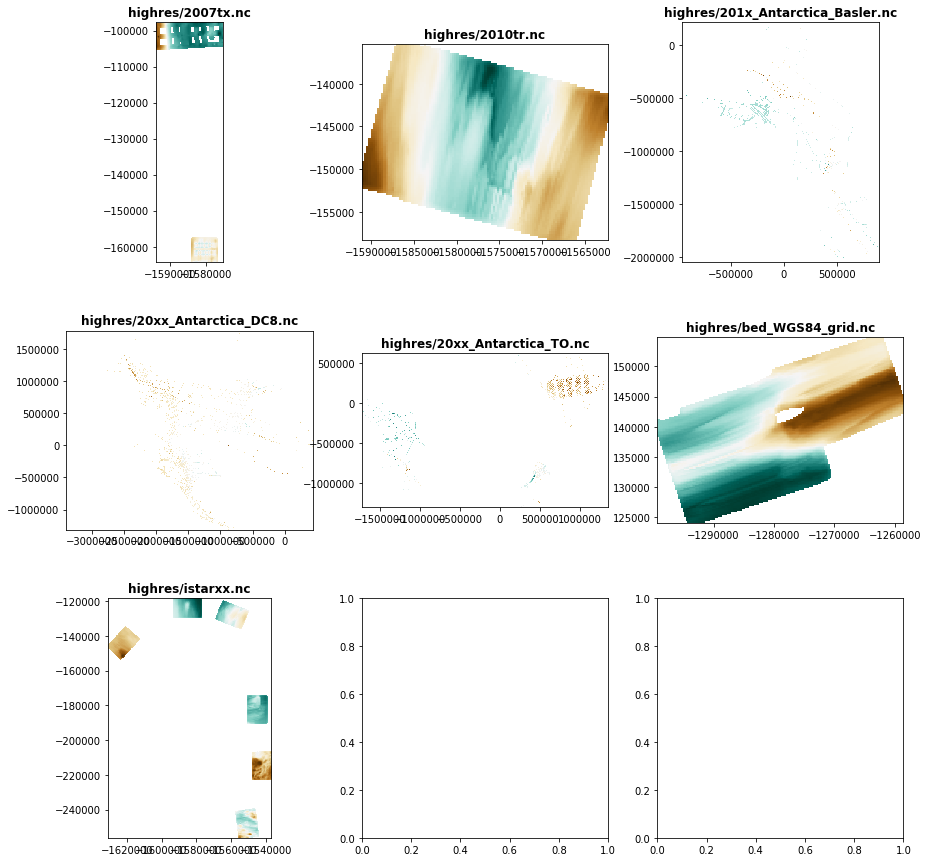

In [16]:
grids = sorted(glob.glob("highres/*.nc"))
fig, axarr = plt.subplots(nrows=1+((len(grids)-1)//3), ncols=3, squeeze=False, figsize=(15,15))

for i, grid in enumerate(grids):
    with rasterio.open(grid) as raster_source:
        rasterio.plot.show(source=raster_source, cmap='BrBG_r', ax=axarr[i//3,i%3], title=grid)

## 3. Tile data

### Big raster to many small square tiles

In [8]:
def get_window_bounds(filepath:str, height:int=32, width:int=32, step=4) -> list:
    """
    Reads in a raster and finds tiles for them according to a stepped moving window.
    Returns a list of bounding box coordinates corresponding to a tile that looks like
    [(minx, miny, maxx, maxy), (minx, miny, maxx, maxy), ...]
    """
    assert(height==width)  #make sure it's a square!
    assert(height%2==0)    #make sure we are passing in an even number
    
    with rasterio.open(filepath) as dataset:
        print(f'Tiling: {filepath} ... ', end='')
        #Vectorized 'loop' along the the raster image from top to bottom, and left to right
        
        #Get boolean true/false mask of where the data/nodata pixels lie
        mask = dataset.read(indexes=list(range(1,dataset.count+1)), masked=True).mask
        mask = np.rollaxis(a=mask, axis=0, start=3)[:,:,0]   #change to shape (height, width)
        
        #Sliding window view of the input geographical raster image
        window_views = skimage.util.shape.view_as_windows(arr_in=mask, window_shape=(height, width), step=step)
        filled_tiles = ~window_views.any(axis=(-2,-1))  #find tiles which are fully filled, i.e. no blank/NODATA pixels
        tile_indexes = np.argwhere(filled_tiles)  #get x and y index of filled tiles
        
        #Convert x,y tile indexes to bounding box coordinates
        windows = [rasterio.windows.Window(col_off=ulx*step, row_off=uly*step, width=width, height=height) for uly, ulx in tile_indexes]
        window_bounds = [rasterio.windows.bounds(window=window, transform=dataset.transform) for window in windows]
        print(len(window_bounds))
    
    return window_bounds

In [9]:
%%time
filepaths = glob.glob("highres/*.tif")
window_bounds = [get_window_bounds(filepath=tif) for tif in filepaths]
window_bounds_concat = np.concatenate([w for w in window_bounds]).tolist()
print(f'Total number of tiles: {len(window_bounds_concat)}')

Tiling: highres/20xx_Antarctica_TO.tif ... 963
Tiling: highres/2010tr.tif ... 131
Tiling: highres/bed_WGS84_grid.tif ... 121
Tiling: highres/20xx_Antarctica_DC8.tif ... 15
Tiling: highres/201x_Antarctica_Basler.tif ... 762
Tiling: highres/istarxx.tif ... 119
Total number of tiles: 2111
CPU times: user 7.19 s, sys: 1.3 s, total: 8.48 s
Wall time: 8.48 s


### Show tiles

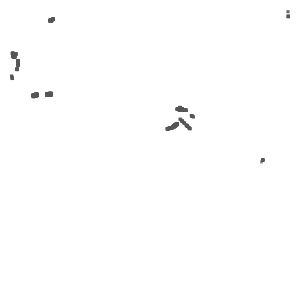

In [10]:
#shapely.geometry.box(*window_bound)
shapely.geometry.MultiPolygon([shapely.geometry.box(*bound) for bound in window_bounds_concat])

### Tile High Resolution data

In [11]:
def selective_tile(filepath:str, window_bounds:list, out_shape:tuple=None) -> np.ndarray:
    """
    Reads in raster and tiles them selectively.
    Tiles will go according to list of window_bounds.
    Output shape can be set to e.g. (16,16) to resample input raster to desired shape/resolution.
    """
    
    array_list = []
    
    with rasterio.open(filepath) as dataset:
        print(f'Tiling: {filepath}')
        for window_bound in window_bounds:
            window = rasterio.windows.from_bounds(*window_bound, transform=dataset.transform, precision=6)
        
            #Read the raster according to the crop window
            array = dataset.read(indexes=list(range(1,dataset.count+1)), masked=True, window=window, out_shape=out_shape)
            array = np.rollaxis(a=array, axis=0, start=3)   #change to shape (height, width, 1)
    
            assert(not array.mask.any())
            assert(array.shape[0]==array.shape[1])  #check that height==width
            array_list.append(array.data.astype(dtype=np.float32))
    
    return np.stack(arrays=array_list)

In [12]:
hireses = [selective_tile(filepath=f, window_bounds=w) for f, w in zip(filepaths, window_bounds)]
hires = np.concatenate(hireses)
print(hires.shape, hires.dtype)

Tiling: highres/20xx_Antarctica_TO.tif
Tiling: highres/2010tr.tif
Tiling: highres/bed_WGS84_grid.tif
Tiling: highres/20xx_Antarctica_DC8.tif
Tiling: highres/201x_Antarctica_Basler.tif
Tiling: highres/istarxx.tif
(2111, 32, 32, 1) float32


### Tile low resolution data

In [13]:
lores = selective_tile(filepath="lowres/bedmap2_bed.tif", window_bounds=window_bounds_concat)
print(lores.shape, lores.dtype)

Tiling: lowres/bedmap2_bed.tif
(2111, 8, 8, 1) float32


### Tile miscellaneous data

In [14]:
rema = selective_tile(filepath="misc/REMA_200m_dem_filled.tif", window_bounds=window_bounds_concat)
print(rema.shape, rema.dtype)

Tiling: misc/REMA_200m_dem_filled.tif
(2111, 40, 40, 1) float32


In [15]:
measuresiceflow = selective_tile(filepath="misc/MEaSUREs_IceFlowSpeed_450m.tif", window_bounds=window_bounds_concat, out_shape=(16,16))
print(measuresiceflow.shape, measuresiceflow.dtype)

Tiling: misc/MEaSUREs_IceFlowSpeed_450m.tif
(2111, 16, 16, 1) float32


## 4. Save the arrays

We'll save the numpy arrays to the filesystem first.
We label inputs as X (low resolution bed DEMs) and W (miscellaneous).
Groundtruth high resolution bed DEMs are labelled as Y.

Also, we'll serve the data up on the web using:
- [Quilt](https://quiltdata.com/) - Python data versioning
- [Dat](https://datproject.org/) - Distributed data sharing (TODO)

In [16]:
os.makedirs(name="model/train", exist_ok=True)
np.save(file="model/train/W1_data.npy", arr=rema)
np.save(file="model/train/W2_data.npy", arr=measuresiceflow)
np.save(file="model/train/X_data.npy", arr=lores)
np.save(file="model/train/Y_data.npy", arr=hires)

### Quilt

Login -> Build -> Push

In [17]:
quilt.login()

Launching a web browser...
If that didn't work, please visit the following URL: https://pkg.quiltdata.com/login



Enter the code from the webpage:  eyJpZCI6ICIyOWI4YzUyNS1lZmM1LTQ5NTItOGQ4Yy03NzQyYTg1YmI1MmEiLCAiY29kZSI6ICI2ODk5YzJjNi1jZjM5LTRiZDgtODkxMS1kZjQxNTk0MWRmOTAifQ==


In [18]:
quilt.build(package='weiji14/deepbedmap/model/train/W1_data', path=rema)
quilt.build(package='weiji14/deepbedmap/model/train/W2_data', path=measuresiceflow)
quilt.build(package='weiji14/deepbedmap/model/train/X_data', path=lores)
quilt.build(package='weiji14/deepbedmap/model/train/Y_data', path=hires)

In [19]:
quilt.push(package='weiji14/deepbedmap', is_public=True)

Fetching upload URLs from the registry...


  0%|          | 0.00/27.2M [00:00<?, ?B/s]

Uploading 5 fragments (27234176 bytes)...


 43%|████▎     | 11.6M/27.2M [00:01<00:02, 5.92MB/s]

Fragment d2081241765e0135511b9b4987cbc399fe5af0e37951fd24ed214ad77a3e0393 already uploaded; skipping.
Fragment 57c2344940a147a198098df7bb1c36d08e0c07a7a12e7cb2fc33c433a2d1fdd0 already uploaded; skipping.
Fragment 17a96a18514c2b5a2de5d02a8bd1adbca398b6a25ea3132779c5515009bdeef1 already uploaded; skipping.
Fragment 8ccc2deee85f761fc9dd2815f5c12c6423939f0a32f49467dd1ee100ac56b877 already uploaded; skipping.


100%|██████████| 27.2M/27.2M [00:03<00:00, 7.58MB/s]


Uploading package metadata...
Updating the 'latest' tag...
Push complete. weiji14/deepbedmap is live:
https://quiltdata.com/package/weiji14/deepbedmap
